# Generate Image

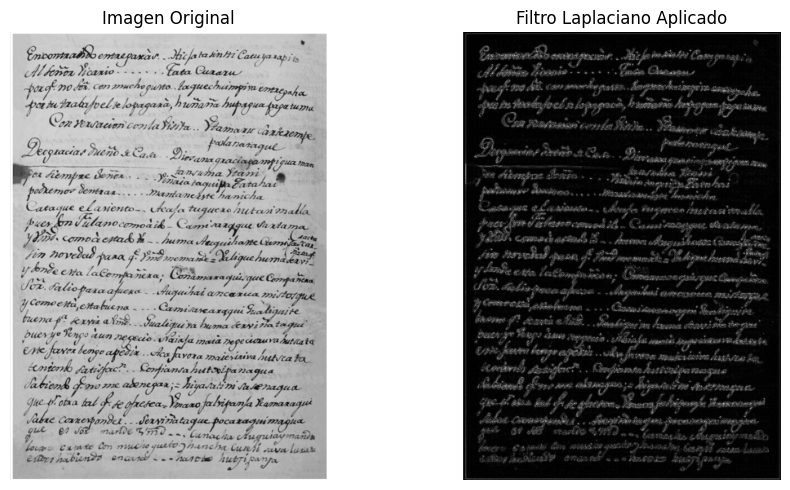

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "./texto.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    axes[1].imshow(laplacian, cmap='gray')
    axes[1].set_title("Filtro Laplaciano Aplicado")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Error: No se pudo cargar la imagen.")



### Cargar imagen en escala de grises

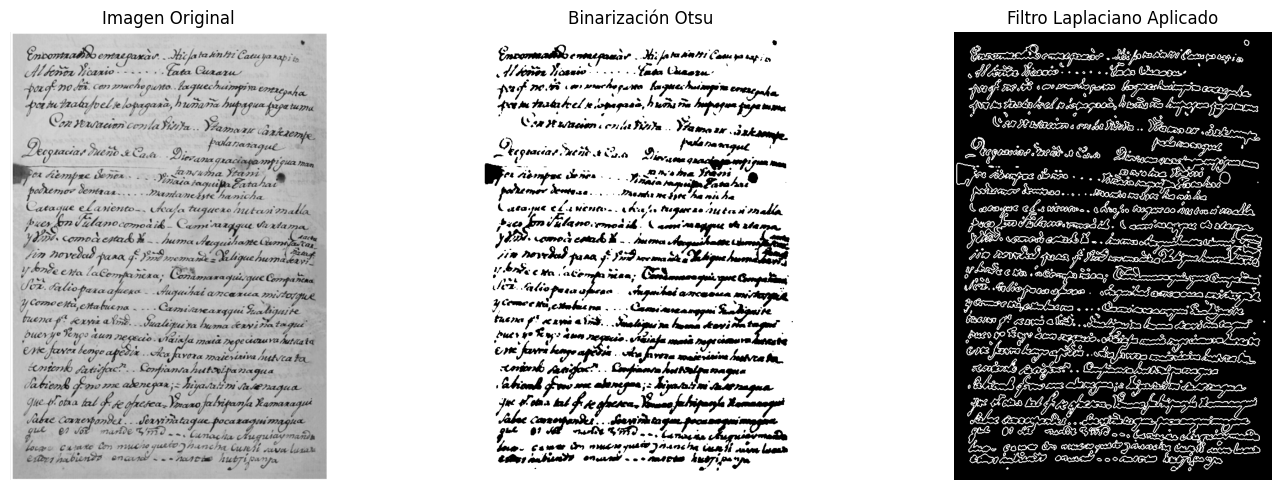

In [7]:

if img is not None:
    # Aplicar filtro Gaussiano para reducir ruido antes de Otsu
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Aplicar binarización Otsu
    _, binary_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Aplicar filtro Laplaciano a la imagen binarizada
    laplacian = cv2.Laplacian(binary_img, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))

    # Crear figura con subgráficos
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 columnas: Original, Binarizada y Laplaciana
    
    # Mostrar imagen original
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    # Mostrar imagen binarizada con Otsu
    axes[1].imshow(binary_img, cmap='gray')
    axes[1].set_title("Binarización Otsu")
    axes[1].axis('off')

    # Mostrar imagen con filtro Laplaciano
    axes[2].imshow(laplacian, cmap='gray')
    axes[2].set_title("Filtro Laplaciano Aplicado")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Error: No se pudo cargar la imagen.")


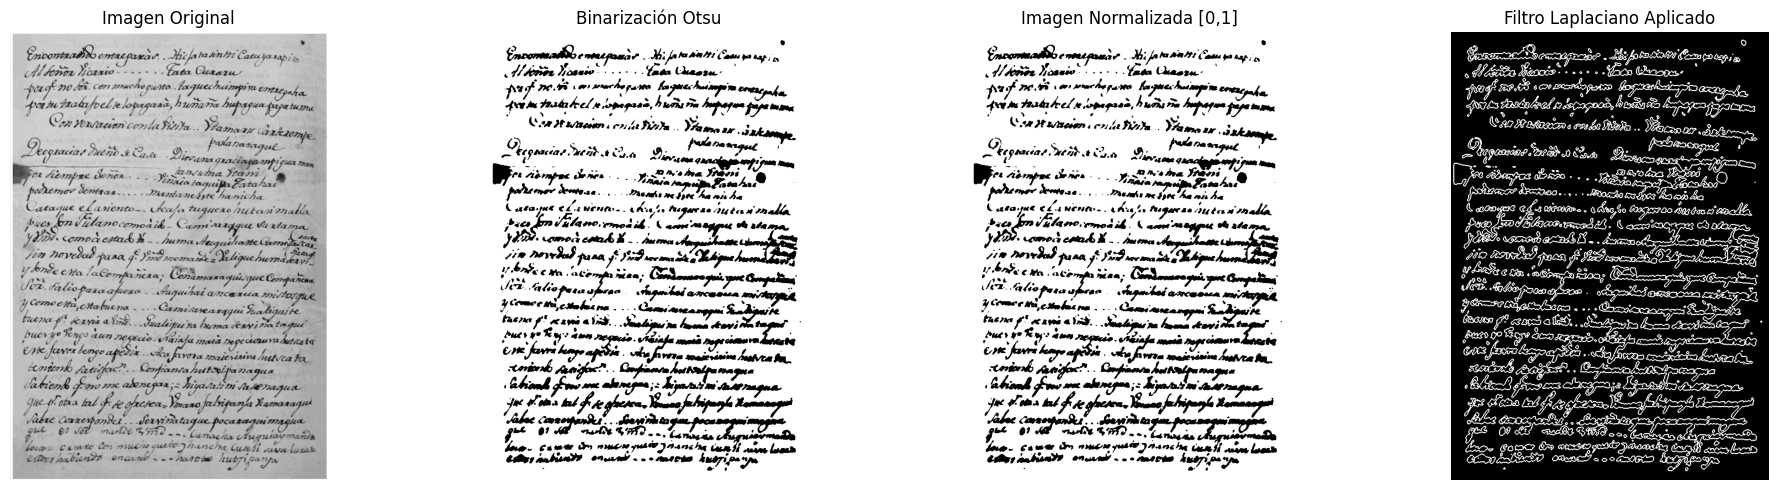

In [12]:
if img is not None:
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    _, binary_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    normalized_img = binary_img.astype(np.float32) / 255.0

    laplacian_input = (normalized_img * 255).astype(np.uint8)

    laplacian = cv2.Laplacian(laplacian_input, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')

    axes[1].imshow(binary_img, cmap='gray')
    axes[1].set_title("Binarización Otsu")
    axes[1].axis('off')

    axes[2].imshow(normalized_img, cmap='gray')
    axes[2].set_title("Imagen Normalizada [0,1]")
    axes[2].axis('off')

    axes[3].imshow(laplacian, cmap='gray')
    axes[3].set_title("Filtro Laplaciano Aplicado")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Error: No se pudo cargar la imagen.")




### Preprocesamiento

In [ ]:
# Preprocesamiento
if img is not None:
    img = cv2.resize(img, (128, 128))  # Redimensionar para el modelo
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    normalized_img = binary_img.astype(np.float32) / 255.0
    laplacian_input = (normalized_img * 255).astype(np.uint8)
    laplacian = cv2.Laplacian(laplacian_input, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian)) / 255.0  # Normalizar a [0,1]

    # Convertir a tensor de PyTorch
    laplacian_tensor = torch.tensor(laplacian, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)


In [ ]:

# Definir el Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Reduce a 64x64
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Reduce a 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Reduce a 16x16
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Para mantener salida en [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:

# Inicializar modelo
autoencoder = Autoencoder()

# Definir pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Entrenar con una sola imagen (para demostración)
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    output = autoencoder(laplacian_tensor)
    loss = criterion(output, laplacian_tensor)  # Minimizar error de reconstrucción
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Visualizar resultado
output_img = output.detach().numpy().squeeze()

plt.subplot(1, 2, 1)
plt.imshow(laplacian, cmap='gray')
plt.title("Imagen Original")

plt.subplot(1, 2, 2)
plt.imshow(output_img, cmap='gray')
plt.title("Reconstrucción Autoencoder")

plt.show()
